In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indian-politics-2004-2019/IndiaVotes_PC__All_States_2009.csv
/kaggle/input/indian-politics-2004-2019/IndiaVotes_PC__All_States_2014.csv
/kaggle/input/indian-politics-2004-2019/2024.csv
/kaggle/input/indian-politics-2004-2019/2019.csv
/kaggle/input/indian-politics-2004-2019/cleaned.csv
/kaggle/input/indian-politics-2004-2019/2004.csv


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/kaggle/input/indian-politics-2004-2019/cleaned.csv')

In [4]:
df.rename(columns={'Unnamed: 0': 'PC'}, inplace=True)

# 2019

In [5]:
# Step 1: Get the unique classes and sort them
original_classes = sorted(df['Party_2019'].unique())

# Step 2: Create a mapping from original classes to new labels starting from 0
label_mapping = {original_classes[i]: i for i in range(len(original_classes))}

# Step 3: Map the original labels in the DataFrame to the new labels
df['Party_2019_mapped'] = df['Party_2019'].map(label_mapping)

# Display the mapping and the new class labels
print("Original classes:", original_classes)
print("Label mapping:", label_mapping)
print("New class labels:", df['Party_2019_mapped'].unique())

Original classes: [0, 1, 2, 3, 4, 6, 7, 8, 12, 15, 17, 18, 19, 21, 22, 23, 26, 32, 34, 39, 41, 42, 46, 47, 49, 51, 52, 53, 54, 55, 56, 57]
Label mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5, 7: 6, 8: 7, 12: 8, 15: 9, 17: 10, 18: 11, 19: 12, 21: 13, 22: 14, 23: 15, 26: 16, 32: 17, 34: 18, 39: 19, 41: 20, 42: 21, 46: 22, 47: 23, 49: 24, 51: 25, 52: 26, 53: 27, 54: 28, 55: 29, 56: 30, 57: 31}
New class labels: [ 2  6  4  3 12 17  8  1  7  9  5 18 25 20 26 15 11 27  0 19 28 16 29 10
 30 22 23 13 21 31 24 14]


In [6]:
features = [
    'State_2004', 'Electors_2004', 'Votes_2004', 'Turnout_2004', 'Margin_2004', 'Margin %_2004',
    'State_2009', 'Electors_2009', 'Votes_2009', 'Turnout_2009', 'Margin_2009', 'Margin %_2009',
    'State_2014', 'Electors_2014', 'Votes_2014', 'Turnout_2014', 'Margin_2014', 'Margin %_2014'
]
target = 'Party_2019_mapped'

In [7]:
X = df[features]
y = df[target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [10]:
params = {
    'objective': 'multiclass',  # Multiclass classification
    'num_class': len(df[target].unique()),  # Number of classes
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'max_depth': 6,  # Depth of the trees
    'learning_rate': 0.05,  # Learning rate
    'metric': 'multi_logloss',  # Metric to evaluate during training
    'verbose': -1  # Suppress training output
}

In [11]:
lgb_model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

In [12]:
y_pred_prob = lgb_model.predict(X_test)
y_pred = [list(prob).index(max(prob)) for prob in y_pred_prob]

party_seat_counts = pd.Series(y_pred).value_counts().sort_index()

print("\nTotal predicted number of seats by each party:")
for party, seats in party_seat_counts.items():
    print(f"Party {party}: {seats} seats")

print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Total predicted number of seats by each party:
Party 0: 1 seats
Party 2: 64 seats
Party 4: 5 seats
Party 5: 2 seats
Party 8: 2 seats
Party 17: 2 seats
Party 25: 1 seats
Model Accuracy: 0.6753246753246753

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.75      0.92      0.83        52
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         4
           5       0.50      0.50      0.50         2
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.50      0.50      0.50         2
           9       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          17       1.00      0.50      0.67         4
          23 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


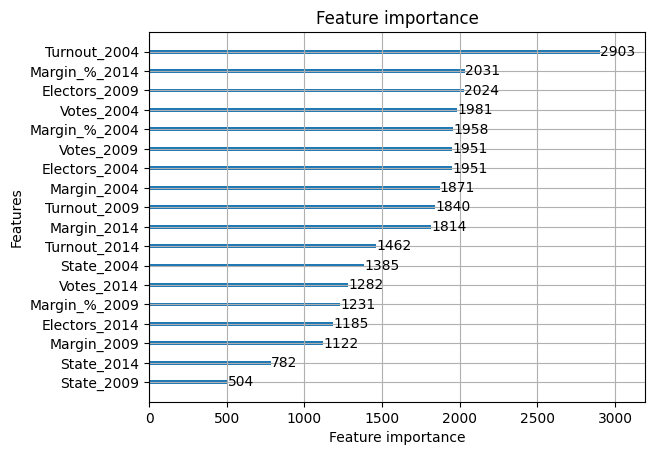

In [13]:
lgb.plot_importance(lgb_model)
plt.show()

# 2024

In [14]:
original_classes_2024 = sorted(df['Party_2024'].unique())

label_mapping_2024 = {original_classes_2024[i]: i for i in range(len(original_classes_2024))}

df['Party_2024_mapped'] = df['Party_2024'].map(label_mapping_2024)

print("Original classes for 2024:", original_classes_2024)
print("Label mapping for 2024:", label_mapping_2024)
print("New class labels for 2024:", df['Party_2024_mapped'].unique())

Original classes for 2024: [1, 2, 4, 6, 7, 8, 11, 13, 17, 18, 21, 22, 25, 29, 32, 34, 42, 47, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
Label mapping for 2024: {1: 0, 2: 1, 4: 2, 6: 3, 7: 4, 8: 5, 11: 6, 13: 7, 17: 8, 18: 9, 21: 10, 22: 11, 25: 12, 29: 13, 32: 14, 34: 15, 42: 16, 47: 17, 51: 18, 53: 19, 54: 20, 56: 21, 57: 22, 58: 23, 59: 24, 60: 25, 61: 26, 62: 27, 63: 28, 64: 29, 65: 30, 66: 31, 67: 32, 68: 33, 69: 34}
New class labels for 2024: [ 1  2  0 23 14 24  7  5 25 26 27  3  6 15 18 10  4 28 29 30 31 16 19 32
  9 12 20 33  8 21 17 34 22 11 13]


In [15]:
features_2024 = [
    'State_2004', 'Electors_2004', 'Votes_2004', 'Turnout_2004', 'Margin_2004', 'Margin %_2004',
    'State_2009', 'Electors_2009', 'Votes_2009', 'Turnout_2009', 'Margin_2009', 'Margin %_2009',
    'State_2014', 'Electors_2014', 'Votes_2014', 'Turnout_2014', 'Margin_2014', 'Margin %_2014',
    'State_2019', 'Electors_2019', 'Votes_2019', 'Turnout_2019', 'Margin_2019', 'Margin %_2019'
]

target_2024 = 'Party_2024_mapped'

X = df[features_2024]
y = df[target_2024]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [18]:
params = {
    'objective': 'multiclass',  # Multiclass classification
    'num_class': len(df[target_2024].unique()),  # Number of classes
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'max_depth': 6,  # Depth of the trees
    'learning_rate': 0.05,  # Learning rate
    'metric': 'multi_logloss',  # Metric to evaluate during training
    'verbose': -1  # Suppress training output
}

In [19]:
lgb_model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[test_data])

In [20]:
y_pred_prob = lgb_model.predict(X_test)
y_pred = [list(prob).index(max(prob)) for prob in y_pred_prob]

party_seat_counts = pd.Series(y_pred).value_counts().sort_index()

print("\nTotal predicted number of seats by each party:")
for party, seats in party_seat_counts.items():
    print(f"Party {party}: {seats} seats")

print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Total predicted number of seats by each party:
Party 0: 8 seats
Party 1: 44 seats
Party 2: 16 seats
Party 5: 1 seats
Party 6: 1 seats
Party 12: 1 seats
Party 14: 4 seats
Party 16: 1 seats
Party 23: 1 seats
Model Accuracy: 0.5584415584415584

Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.67      0.36         3
           1       0.73      0.76      0.74        42
           2       0.25      0.27      0.26        15
           4       0.00      0.00      0.00         1
           5       1.00      1.00      1.00         1
           6       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         0
          14       1.00      0.80      0.89         5
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         1
          18       0.00      0.00      0.00         1
          23       0.00      0

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.

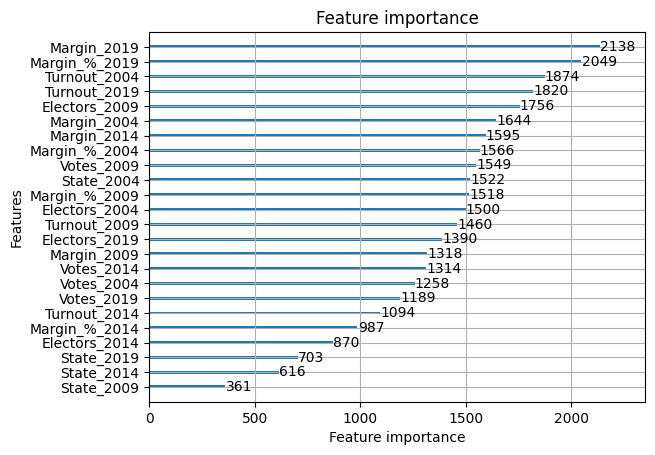

In [21]:
lgb.plot_importance(lgb_model)
plt.show()